In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
os.environ['CUDA'] = torch.version.cuda
print(os.environ['TORCH'])

!pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric

from torch.nn import ReLU, Softmax, LogSoftmax
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import DBLP
import torch_geometric.transforms as T
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import Sequential, Linear, GCNConv, SAGEConv, to_hetero
from torch_geometric.utils import spmm

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 30.1 MB/s eta 0:00:00


In [2]:
dataset = DBLP("q1")
data = dataset[0]

Extracting q1/raw/DBLP_processed.zip
Processing...
Done!


In [3]:
num_classes = len(np.unique(data["author"].y))
print(dataset)
print("Number of graphs:", len(dataset))
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Number of node features:", data.num_node_features)
print("Number of edge features:", data.num_edge_features)
print("Number of classes:", num_classes)
print("Average node degree:", round(data.num_edges / data.num_nodes, 2))
print("Number of training nodes:", data["author"].train_mask.sum().item())
print("Number of validation nodes:", data["author"].val_mask.sum().item())
print("Number of test nodes:", data["author"].test_mask.sum().item())
print("Is directed:", data.is_directed())
print("Has isolated nodes:", data.has_isolated_nodes())
print("Has self loops:", data.has_self_loops())
print()
print("Other information:")
print(data)

DBLP()
Number of graphs: 1
Number of nodes: 26128
Number of edges: 239566
Number of node features: {'author': 334, 'paper': 4231, 'term': 50, 'conference': 0}
Number of edge features: {('author', 'to', 'paper'): 0, ('paper', 'to', 'author'): 0, ('paper', 'to', 'term'): 0, ('paper', 'to', 'conference'): 0, ('term', 'to', 'paper'): 0, ('conference', 'to', 'paper'): 0}
Number of classes: 4
Average node degree: 9.17
Number of training nodes: 400
Number of validation nodes: 400
Number of test nodes: 3257
Is directed: False
Has isolated nodes: False
Has self loops: False

Other information:
HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },

In [4]:
data = T.Constant(node_types="conference")(data)
data = T.ToUndirected()(data)
data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)
data = data.to(device)

In [5]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data["author"].train_mask
    loss = F.cross_entropy(out["author"][mask], data["author"].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)["author"].argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data["author"][split]
        acc = (pred[mask] == data["author"].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


def epoch_plot(model, optimizer, max_epoch=100, save="epoch.png"):
    values = []
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Epoch", y="Loss", ax=ax[0])
    sns.lineplot(data=df, x="Epoch", y="Train", label="Train", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Validation", label="Validation", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Test", label="Test", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()


def eval(model, optimizer, max_epoch=100):
    values = []
    t = time.time()
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    t = time.time() - t
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    acc = df.iloc[-1, -1]
    print(f"Accuracy: {acc:.4f}")
    print(f"Computation Time: {t:.4f}s")

In [113]:
class SGC(MessagePassing):
    def __init__(self, in_channels, out_channels, K=1, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.lin = Linear(in_channels, out_channels, bias=True)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index, size=None):
        for k in range(self.K):
            x = self.propagate(edge_index, x=x, size=size)
        return self.lin(x)

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return spmm(adj_t, x, reduce=self.aggr)


def gcn(hidden_channels=64):
    """GCN net implemeted similar to the original paper"""
    torch.manual_seed(1234567)
    layers = [
        (SAGEConv((-1, -1), hidden_channels, aggr="mean"), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (SAGEConv((-1, -1), num_classes, aggr="mean"), 'x, edge_index -> x'),
        Softmax(dim=1),
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model


def sgc():
    """SGC net implemeted similar to the original paper"""
    torch.manual_seed(1234567)
    layers = [
        (SGC(-1, num_classes, k=1, aggr="mean"), 'x, edge_index -> x'),
        Softmax(dim=1),
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

  
def mynet():
    torch.manual_seed(1234567)
    layers = [
        (Linear(-1, 64), 'x -> x'),
        (Linear(-1, num_classes), 'x -> x'),
        Softmax(dim=1),
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

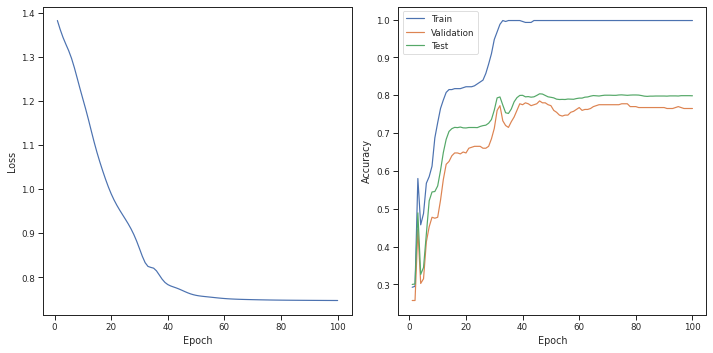

In [36]:
model = gcn(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epoch_plot(model, optimizer, max_epoch=100, save="gcn_epoch.png")

In [108]:
model = gcn(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
eval(model, optimizer, max_epoch=100)

Accuracy: 0.7817
Computation Time: 23.9660s


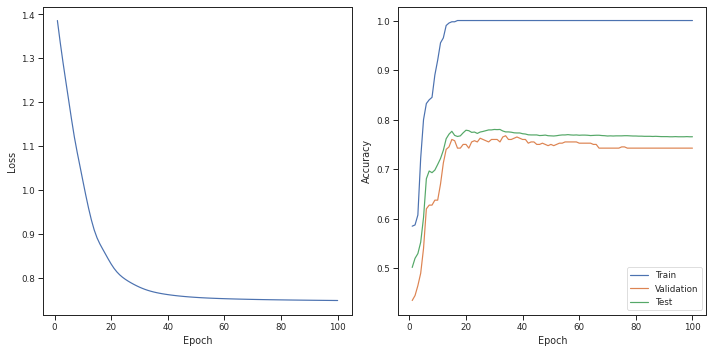

In [29]:
model = sgc()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
epoch_plot(model, optimizer, max_epoch=100, save="sgc_epoch.png")

In [116]:
model = sgc()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
eval(model, optimizer, max_epoch=100)

Accuracy: 0.7657
Computation Time: 15.4944s


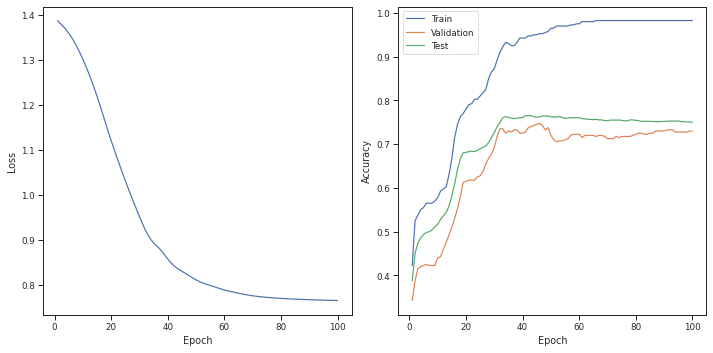

In [104]:
model = mynet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
epoch_plot(model, optimizer, max_epoch=100, save="mynet_epoch.png")

In [101]:
model = mynet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
eval(model, optimizer, max_epoch=100)

Accuracy: 0.7639
Computation Time: 0.8900s
